**这个Notebook需要dmg文件夹中文件, 其他函数在Notebook中定义.**

## Package Import

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg

## Define R, P, Poisson, Nonlinear Poisson

In [4]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    outputsize = int((2**(np.log2(np.sqrt(inputsize)+1)-1)-1)**2)
    sqrtoutputsize = int(np.sqrt(outputsize))
    OUTPUT = np.zeros([outputsize, inputsize])
    for j in range(sqrtoutputsize):
        for i in range(sqrtoutputsize):
            OUTPUT[i+sqrtoutputsize*j][2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][1+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/4
            OUTPUT[i+sqrtoutputsize*j][2+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2*sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2 *
                                       sqrtinputsize + 2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2 *
                                       sqrtinputsize+2*i+j*2*sqrtinputsize] = 1/16
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    A1 = 2*np.eye(sqrtinputsize)
    for i in range(sqrtinputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    I = np.eye(sqrtinputsize)
    OUTPUT = (np.kron(I, A1)+np.kron(A1, I))
    return OUTPUT


def NonlinearPoisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    h = 1/(sqrtinputsize-1)
    KX = np.zeros([inputsize,inputsize+1])
    KY = np.zeros([inputsize+1,inputsize])
    for i in range(sqrtinputsize):
        for j in range(sqrtinputsize+1):
            KX[i][j] = a(j*h-0.5*h,i*h)
    for i in range(sqrtinputsize+1):
        for j in range(sqrtinputsize):
            KY[i][j] = a(j*h,i*h-0.5*h)
    OUTPUT = (gallery.nonlinearPoisson((sqrtinputsize,sqrtinputsize),KX,KY)).to_full()
    return OUTPUT

## Define Multigrid

In [5]:
def Multigrid_circle(inputsize, A_A, B, R_A, s, w, NUM_EPOCH):
    A = np.matrix(A_A)
    P = 4*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    for i in range(NUM_EPOCH):
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

## Define Spectral Radius Calculator

In [6]:
def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def rhoAuto(INPUT):
    R = INPUT[0]
    w = INPUT[1]
    P = 4*np.transpose(R)
    M = (w**(-1)) * np.diag(np.diag(A1))
    K = M - A1
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A1),P))),R),A1)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

## Define Optimizer

In [7]:
def optimizer_GD(inputsize, A, R, w, s, learning_rate):
    rhoold = rho(inputsize,A,4*np.transpose(R),R,w,s)
    INPUT = [R,w]
    rhoGra = grad(rhoAuto)
    delta = rhoGra(INPUT)
    R -= learning_rate*delta[0]
    w -= learning_rate*delta[1]
    rhonew = rho(inputsize,A,4*np.transpose(R),R,w,s)
    return R, w, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate)
        R = Rnew
        w = wnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            P = 4*np.transpose(R)
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhonew <= rhoold and i<100:
        Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate)
        R = Rnew
        Radius.append(Rnew)
        w = wnew
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

In [8]:
finegridsize = 5
s = 1
w = 2/3
MAX_ITER = 50

# Experiment (with large e1, e2, e3, e4, e5)

选取比较大的参数, a函数频率较小

In [9]:
e = 1
def u_real(x, y): return np.sin(np.pi*3*x)*np.sin(np.pi*5*y)
def rightf(x, y): return  34*np.pi**2*np.sin(3*np.pi*x)*np.sin(5*np.pi*y)*(np.cos((x + y)/e) + 2) + (3*np.pi*np.cos(3*np.pi*x)*np.sin(5*np.pi*y)*np.sin((x + y)/e))/e + (5*np.pi*np.cos(5*np.pi*y)*np.sin(3*np.pi*x)*np.sin((x + y)/e))/e
def a(x, y): return 2+np.cos((x+y)/e)

**Plot $a(x,y)$**

In [24]:
inputsize = (2**finegridsize-1)**2
inputsize = int(inputsize)
sqrtinputsize = int(np.sqrt(inputsize))
outputsize = int((2**(np.log2(np.sqrt(inputsize)+1)-1)-1)**2)
sqrtoutputsize = int(np.sqrt(outputsize))
h = 1/(sqrtinputsize-1)
A0 = Poisson(inputsize)
A1 = NonlinearPoisson(inputsize)
[X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
RightF = rightf(X,Y)*h**2
RightF = RightF.reshape(inputsize, 1)
Ureal = u_real(X,Y).reshape(inputsize, 1)
R = Restriction(inputsize)
P = 4*np.transpose(R)

**Plot A0, A1**

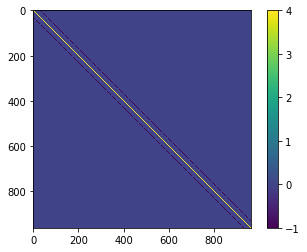

In [11]:
plt.imshow(A0)
plt.colorbar()

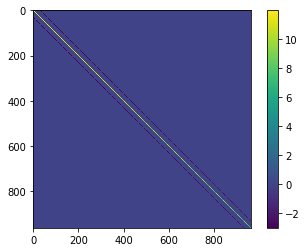

In [12]:
plt.imshow(A1)
plt.colorbar()


## GMM

**Calculate Result and Residual**

In [13]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1, RightF, R, s, w, MAX_ITER)

Residual = 13.234533884546389
Interation = 0
Residual = 1.4928317482876177
Interation = 1
Residual = 0.29967999366759573
Interation = 2
Residual = 0.07820568862519942
Interation = 3
Residual = 0.026166085035206864
Interation = 4
Residual = 0.009853287764105158
Interation = 5
Residual = 0.0038760236086638165
Interation = 6
Residual = 0.0015540075873265312
Interation = 7
Residual = 0.0006298187418625293
Interation = 8
Residual = 0.0002571344710190374
Interation = 9
Residual = 0.00010555242105121943
Interation = 10
Residual = 4.3513200519128145e-05
Interation = 11
Residual = 1.7999494301947313e-05
Interation = 12
Residual = 7.466621904177039e-06
Interation = 13
Residual = 3.1046598799811525e-06
Interation = 14
Residual = 1.2935256882392963e-06
Interation = 15
Residual = 5.39863224062173e-07
Interation = 16
Residual = 2.2565228540403142e-07
Interation = 17
Residual = 9.444091867633396e-08
Interation = 18
Residual = 3.9570892451137996e-08
Interation = 19
Residual = 1.6596941326919712e-08
In

In [26]:
np.linalg.norm(Ureal - GMM_U.reshape(inputsize, 1),np.inf)

0.3870523760294594

**Plot Result**

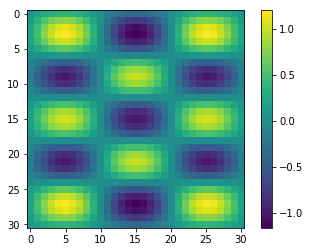

In [21]:
plt.imshow(GMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

**Plot Residual**

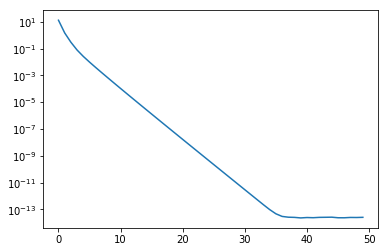

In [14]:
plt.semilogy(GMM_Res)

**Calculate Spectral Radius**

In [15]:
GMM_Radius = rho(inputsize,A1,4*np.transpose(R),R,w,s)
print('GMM_Radius = {}'.format(GMM_Radius))

GMM_Radius = 0.45417739461495643


## AMG

**Define Solver and Solve**

In [16]:
amg_solver = pyamg.classical.classical.ruge_stuben_solver(A1,max_levels = 2)
pyamg.relaxation.smoothing.change_smoothers(amg_solver,presmoother=("jacobi", {"omega": w, "iterations": s}),postsmoother=("jacobi", {"omega": w, "iterations": s}))
AMG_Res = []
print(amg_solver)
AMG_U= amg_solver.solve(RightF, maxiter = MAX_ITER, tol=0, residuals=AMG_Res)

multilevel_solver
Number of Levels:     2
Operator Complexity:  1.872
Grid Complexity:      1.501
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0          961         4681 [53.42%]
    1          481         4081 [46.58%]



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pyamg/classical/classical.py:98: SparseEfficiencyWarning: Implicit conversion of A to CSR
  SparseEfficiencyWarning)


**Plot Result**

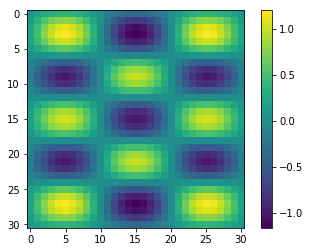

In [17]:
plt.imshow(AMG_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

**Plot Residual**

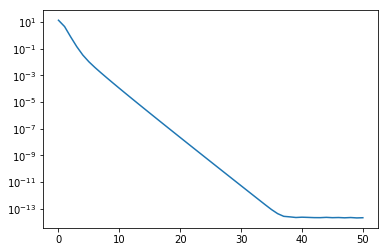

In [18]:
plt.semilogy(AMG_Res)

## DMM with full R optimization

**Optimize R, P, $\omega$**

learning_rate是梯度下降时步长, step_length是每一个M之间的距离, 两者都必须非常小, 不然会出现不好的结果.

In [19]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1, Restriction(inputsize),  2/3, s, learning_rate = 1e-1,accept_radius = GMM_Radius,step_length = 1e-1)

======Section 1======
L = 0.2
rho = 0.4068218442370402
Decrease the step_length, learning_rate and Restart!!
step_length = 0.010000000000000002
learning_rate = 0.010000000000000002
rhonew = 0.5887920883347318
L = 0.020000000000000004
rho = 0.44921703847867095
L = 0.030000000000000006
rho = 0.4444076040563741
L = 0.04000000000000001
rho = 0.43968236038822645
L = 0.05000000000000001
rho = 0.43521011506890817
L = 0.06000000000000001
rho = 0.433683168814176
Decrease the step_length, learning_rate and Restart!!
step_length = 0.0010000000000000002
learning_rate = 0.0010000000000000002
rhonew = 0.5119549476119105
L = 0.0020000000000000005
rho = 0.45359367457873156
L = 0.003000000000000001
rho = 0.453106424151672
L = 0.004000000000000001
rho = 0.45261972499580827
L = 0.005000000000000001
rho = 0.45213357296223966
L = 0.006000000000000001
rho = 0.4516479667963637
L = 0.007000000000000001
rho = 0.45116290618538135
L = 0.008000000000000002
rho = 0.45067839103301494
L = 0.009000000000000003
rho = 

L = 0.10900000000000008
rho = 0.4044476653194737
L = 0.11000000000000008
rho = 0.4040156310661564
L = 0.11100000000000008
rho = 0.40358408008610863
L = 0.11200000000000009
rho = 0.40315301180513896
L = 0.11300000000000009
rho = 0.40272242564994726
L = 0.11400000000000009
rho = 0.4022923210481213
L = 0.11500000000000009
rho = 0.40186269742813363
L = 0.11600000000000009
rho = 0.4014335542193387
L = 0.11700000000000009
rho = 0.401004890851969
L = 0.11800000000000009
rho = 0.400576706757133
L = 0.11900000000000009
rho = 0.4001490013668112
L = 0.12000000000000009
rho = 0.3997217741138533
L = 0.1210000000000001
rho = 0.39929502443197507
L = 0.1220000000000001
rho = 0.39886875175575537
L = 0.1230000000000001
rho = 0.39844295552063275
L = 0.1240000000000001
rho = 0.39801763516290284
L = 0.12500000000000008
rho = 0.39759279011971466
L = 0.12600000000000008
rho = 0.3971684198290683
L = 0.12700000000000009
rho = 0.396744523729811
L = 0.12800000000000009
rho = 0.396321101261635
L = 0.1290000000000

L = 0.22800000000000017
rho = 0.3671195779734299
L = 0.22900000000000018
rho = 0.3671988771817822
L = 0.23000000000000018
rho = 0.3675308565914044
L = 0.23100000000000018
rho = 0.3689230899418358
L = 0.23200000000000018
rho = 0.37505102011953856
L = 0.23300000000000018
rho = 0.40060735132490183
L = 0.23400000000000018
rho = 0.4383579329427068
L = 0.23500000000000018
rho = 0.4484674275102086
L = 0.23600000000000018
rho = 0.4462543905959406
L = 0.23700000000000018
rho = 0.4451001022615121
L = 0.23800000000000018
rho = 0.44320018912615605
L = 0.23900000000000018
rho = 0.44119527487544735
L = 0.24000000000000019
rho = 0.43901579456487355
L = 0.2410000000000002
rho = 0.43675594940160684
L = 0.2420000000000002
rho = 0.4344322493454381
L = 0.2430000000000002
rho = 0.43207155477982945
L = 0.2440000000000002
rho = 0.42968598702501276
L = 0.2450000000000002
rho = 0.42728458438219563
L = 0.2460000000000002
rho = 0.42487020574187423
L = 0.2470000000000002
rho = 0.4224399117639001
L = 0.24800000000

L = 0.34800000000000025
rho = 0.3669752430332146
L = 0.34900000000000025
rho = 0.36701368648217547
L = 0.35000000000000026
rho = 0.367155415707863
L = 0.35100000000000026
rho = 0.36766952952721443
L = 0.35200000000000026
rho = 0.36952451765166777
L = 0.35300000000000026
rho = 0.37645033571544023
L = 0.35400000000000026
rho = 0.4003838475118781
L = 0.35500000000000026
rho = 0.43077476025990485
L = 0.35600000000000026
rho = 0.4389471996318441
L = 0.35700000000000026
rho = 0.43779762417723483
L = 0.35800000000000026
rho = 0.4364875974226917
L = 0.35900000000000026
rho = 0.4347280496018638
L = 0.36000000000000026
rho = 0.4327441262786674
L = 0.36100000000000027
rho = 0.4306024978688928
L = 0.36200000000000027
rho = 0.42835879483398526
L = 0.36300000000000027
rho = 0.4260447481640805
L = 0.36400000000000027
rho = 0.42367919682056154
L = 0.36500000000000027
rho = 0.42126887712925387
L = 0.36600000000000027
rho = 0.41880711694482115
L = 0.36700000000000027
rho = 0.4162680511064099
L = 0.36800

L = 0.46700000000000036
rho = 0.43128749810847794
L = 0.46800000000000036
rho = 0.4298413839171701
L = 0.46900000000000036
rho = 0.42803411376502115
L = 0.47000000000000036
rho = 0.426004138530616
L = 0.47100000000000036
rho = 0.4238245665432664
L = 0.47200000000000036
rho = 0.4215386728904759
L = 0.47300000000000036
rho = 0.41916661416670936
L = 0.47400000000000037
rho = 0.41670644222087466
L = 0.47500000000000037
rho = 0.414126689283628
L = 0.47600000000000037
rho = 0.4113429121992725
L = 0.47700000000000037
rho = 0.4081504756345555
L = 0.47800000000000037
rho = 0.40399647565585206
L = 0.47900000000000037
rho = 0.39706391377990935
L = 0.48000000000000037
rho = 0.3885599074365765
L = 0.48100000000000037
rho = 0.38812696203960984
L = 0.4820000000000004
rho = 0.3877235168072103
L = 0.4830000000000004
rho = 0.38732056499419815
L = 0.4840000000000004
rho = 0.3869180612573358
L = 0.4850000000000004
rho = 0.38651605903282615
L = 0.4860000000000004
rho = 0.38611460676634307
L = 0.48700000000

L = 0.5870000000000004
rho = 0.38514809845858
L = 0.5880000000000004
rho = 0.384737954940655
L = 0.5890000000000004
rho = 0.3843282730828605
L = 0.5900000000000004
rho = 0.3839190523375322
L = 0.5910000000000004
rho = 0.38351029216134386
L = 0.5920000000000004
rho = 0.3831019920184666
L = 0.5930000000000004
rho = 0.38269415138434765
L = 0.5940000000000004
rho = 0.38228676975070125
L = 0.5950000000000004
rho = 0.3818798466324117
L = 0.5960000000000004
rho = 0.3814733815772513
L = 0.5970000000000004
rho = 0.38106737417965264
L = 0.5980000000000004
rho = 0.3806618241002647
L = 0.5990000000000004
rho = 0.38025673109372976
L = 0.6000000000000004
rho = 0.3798520950481168
L = 0.6010000000000004
rho = 0.37944791604086503
L = 0.6020000000000004
rho = 0.3790441944180825
L = 0.6030000000000004
rho = 0.3786409309068479
L = 0.6040000000000004
rho = 0.37823812677409524
L = 0.6050000000000004
rho = 0.37783578405116763
L = 0.6060000000000004
rho = 0.37743390585080805
L = 0.6070000000000004
rho = 0.377

L = 0.7070000000000005
rho = 0.3743996676256034
L = 0.7080000000000005
rho = 0.37402888080160807
L = 0.7090000000000005
rho = 0.3736595804459989
L = 0.7100000000000005
rho = 0.3732918047576588
L = 0.7110000000000005
rho = 0.3729255895108331
L = 0.7120000000000005
rho = 0.37256096764312335
L = 0.7130000000000005
rho = 0.37219796958157153
L = 0.7140000000000005
rho = 0.3718366250902327
L = 0.7150000000000005
rho = 0.3714769680304668
L = 0.7160000000000005
rho = 0.37111904645155464
L = 0.7170000000000005
rho = 0.3707629421283673
L = 0.7180000000000005
rho = 0.3704088063834367
L = 0.7190000000000005
rho = 0.37005692312753663
L = 0.7200000000000005
rho = 0.3697078154783795
L = 0.7210000000000005
rho = 0.36936241733259273
L = 0.7220000000000005
rho = 0.36902232917308725
L = 0.7230000000000005
rho = 0.3686901503932048
L = 0.7240000000000005
rho = 0.3683697956244041
L = 0.7250000000000005
rho = 0.36806653972900283
L = 0.7260000000000005
rho = 0.36778641282507435
L = 0.7270000000000005
rho = 0.

L = 0.8270000000000006
rho = 0.366609958470846
L = 0.8280000000000006
rho = 0.36659481462628685
L = 0.8290000000000006
rho = 0.3665855239900542
L = 0.8300000000000006
rho = 0.36657982561777797
L = 0.8310000000000006
rho = 0.3665762712735035
L = 0.8320000000000006
rho = 0.36657396936566794
L = 0.8330000000000006
rho = 0.36657238777087936
L = 0.8340000000000006
rho = 0.36657121626982164
L = 0.8350000000000006
rho = 0.36657027708202694
L = 0.8360000000000006
rho = 0.36656946950492364
L = 0.8370000000000006
rho = 0.36656873692381303
L = 0.8380000000000006
rho = 0.3665680475918215
L = 0.8390000000000006
rho = 0.3665673837219059
L = 0.8400000000000006
rho = 0.36656673526428235
L = 0.8410000000000006
rho = 0.3665660965411304
L = 0.8420000000000006
rho = 0.3665654642456419
L = 0.8430000000000006
rho = 0.3665648365436516
L = 0.8440000000000006
rho = 0.3665642124013663
L = 0.8450000000000006
rho = 0.36656359169973124
L = 0.8460000000000006
rho = 0.36656297542565924
L = 0.8470000000000006
rho = 0

L = 0.9470000000000007
rho = 0.36750698100193613
L = 0.9480000000000007
rho = 0.36889828029095656
L = 0.9490000000000007
rho = 0.3717179832388717
L = 0.9500000000000007
rho = 0.37710298413456694
L = 0.9510000000000007
rho = 0.3878956387341188
L = 0.9520000000000007
rho = 0.4035870434252083
L = 0.9530000000000007
rho = 0.41185225774504386
L = 0.9540000000000007
rho = 0.41242610374424477
L = 0.9550000000000007
rho = 0.4108804931584443
L = 0.9560000000000007
rho = 0.4087455740037421
L = 0.9570000000000007
rho = 0.4061819697468617
L = 0.9580000000000007
rho = 0.4030337788547165
L = 0.9590000000000007
rho = 0.3986846769879112
L = 0.9600000000000007
rho = 0.3908938715124073
L = 0.9610000000000007
rho = 0.3813330252980418
L = 0.9620000000000007
rho = 0.38094137321138016
L = 0.9630000000000007
rho = 0.38055140616073807
L = 0.9640000000000007
rho = 0.38016259535162344
L = 0.9650000000000007
rho = 0.3797747937526752
L = 0.9660000000000007
rho = 0.3793879667362389
L = 0.9670000000000007
rho = 0.3

**Calculate Result and Residual**

In [20]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1, RightF, Rnew, s, wnew, MAX_ITER)

Residual = 13.067386627215795
Interation = 0
Residual = 0.8798352369435396
Interation = 1
Residual = 0.13278912103373816
Interation = 2
Residual = 0.0317884894906772
Interation = 3
Residual = 0.009206386419752379
Interation = 4
Residual = 0.0028156533362460184
Interation = 5
Residual = 0.0008819341781582632
Interation = 6
Residual = 0.00028043317027879857
Interation = 7
Residual = 9.015074357670263e-05
Interation = 8
Residual = 2.9224674229548467e-05
Interation = 9
Residual = 9.536659114188612e-06
Interation = 10
Residual = 3.128488419965316e-06
Interation = 11
Residual = 1.030682909296436e-06
Interation = 12
Residual = 3.407420742046724e-07
Interation = 13
Residual = 1.1297109797654379e-07
Interation = 14
Residual = 3.754360959764378e-08
Interation = 15
Residual = 1.2501456558908437e-08
Interation = 16
Residual = 4.169684554806273e-09
Interation = 17
Residual = 1.392679003596819e-09
Interation = 18
Residual = 4.657085702629098e-10
Interation = 19
Residual = 1.5588945506519974e-10
Inte

In [21]:
np.linalg.norm(Ureal - DMM_U,np.inf)

0.3870523760294596

**Plot Result**

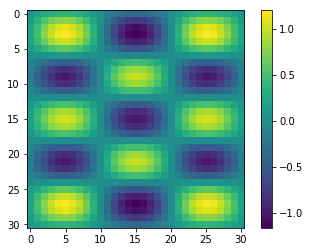

In [22]:
plt.imshow(DMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

**Plot Residual**

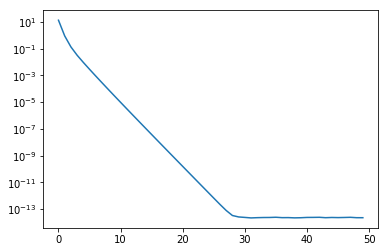

In [23]:
plt.semilogy(DMM_Res)

**Calculate Spectral Radius**

In [24]:
DMM_Radius = Rhonew
print('DMM_Radius = {}'.format(DMM_Radius))

DMM_Radius = 0.3664617461768567


R under log10(abs())


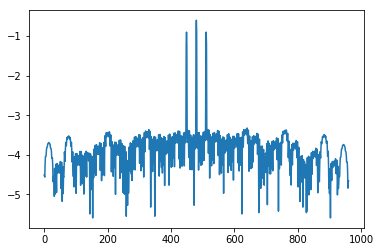

In [25]:
print("R under log10(abs())")
plt.plot(np.log10(np.abs(Rnew))[round(0.5*outputsize)][:])

## DMM with nine point scheme optimizer

**Build the stiff matrix**

In [26]:
num_levels=2
n=sqrtinputsize
kx = np.zeros([n,n+1])
ky = np.zeros([n+1,n])
for i in range(n):
    for j in range(n+1):
        kx[i][j] = a((j-0.5)*h,i*h)
for i in range(n+1):
    for j in range(n):
        ky[i][j] = a(j*h,(i-0.5)*h)    
A = gallery.nonlinearPoisson((n,n), kx, ky)

In [27]:
PR_stencil_type = "m9p"
gmm = dgmg.DeepMG(A, PR_stencil_type=PR_stencil_type, max_levels=num_levels)
num_iter = 2500
step_size = 1e-4
opt_par = gmm.optimize(num_iter=num_iter, step_size=step_size)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Iteration 100/2500
Upper bound estimation = 0.21604874912228308
Iteration 200/2500
Upper bound estimation = 0.20641712206364118
Iteration 300/2500
Upper bound estimation = 0.19412286762893313
Iteration 400/2500
Upper bound estimation = 0.18487917093974549
Iteration 500/2500
Upper bound estimation = 0.17598866392639578
Iteration 600/2500
Upper bound estimation = 0.1687812922293808
Iteration 700/2500
Upper bound estimation = 0.1643428978815126
Iteration 800/2500
Upper bound estimation = 0.1580201397124885
Iteration 900/2500
Upper bound estimation = 0.1506858032490362
Iteration 1000/2500
Upper bound estimation = 0.146870406768062
Iteration 1100/2500
Upper bound estimation = 0.13967399916086276
Iteration 1200/2500
Upper bound estimation = 0.13646052468625083
Iteration 1300/2500
Upper bound estimation = 0.13169457017592975
Iteration 1400/2500
Upper bound estimation = 0.13201461674671205
Iteration 1500/2500
Upper bound estimation = 0.132908069262354
Iteration 1600/2500
Upper bound estimation

In [28]:
print(gmm)
convergence = gmm.get_optimizer_convergence()
conv_time = gmm.get_optimization_time()
gmm.update_prd(opt_par)
DMM_rho = gmm.compute_rho()
print("DMM rho = {}".format(DMM_rho))

Dimension of matrix A for levels:
Level = 0, dimension = (15, 15)
Level = 1, dimension = (31, 31)

DMM rho = 0.11759123112127572


[1.32680611e+01 1.07736477e+00 9.89145536e-02 1.08750513e-02
 9.48502377e-04 8.65367895e-05 8.36895475e-06 8.59530054e-07
 9.10569403e-08 9.91557661e-09 1.09179031e-09 1.21312601e-10
 1.35793322e-11 1.53065698e-12 1.73628288e-13 2.57930911e-14
 1.44705368e-14 1.41888778e-14 1.37441151e-14 1.49448416e-14
 1.35826258e-14 1.38431149e-14 1.41207171e-14 1.42064377e-14
 1.53496346e-14 1.45278254e-14 1.51673398e-14 1.48361809e-14
 1.47050466e-14 1.65775967e-14 1.49900906e-14 1.65814665e-14
 1.59217039e-14 1.47004346e-14 1.48371034e-14 1.43414318e-14
 1.51961515e-14 1.50348626e-14 1.56232199e-14 1.34444231e-14
 1.42212603e-14 1.51300694e-14 1.52238690e-14 1.39246755e-14
 1.53018412e-14 1.45593003e-14 1.49903312e-14 1.80797802e-14
 1.69380502e-14 1.48704796e-14]


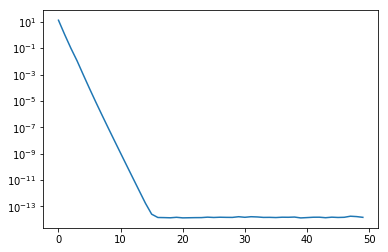

In [29]:
x = gmm.solve(RightF, np.random.randn(A.shape), tol=0, max_iter=50)
print(gmm.get_gmg_convergence())
plt.semilogy(gmm.get_gmg_convergence())

In [30]:
np.linalg.norm(Ureal - x,np.inf)

0.3870523760294595

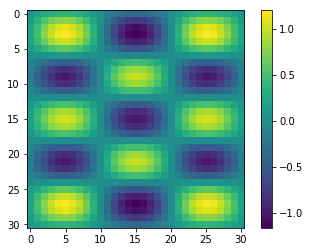

In [31]:
x = x.reshape(A.dim)
plt.imshow(x)
plt.colorbar()

In [32]:
np.set_printoptions(threshold=np.inf)
print("omega = {}".format(opt_par[2]))

omega = 0.7920372954575321


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log10
  return f_raw(*args, **kwargs)


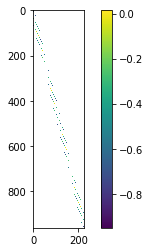

In [33]:
P = opt_par[0][0]
k = int(2**(np.log2(n+1)-1)-1) 
P_Matrix = np.zeros([n**2,k**2])
for i in range(k):
    for j in range(k):
        C = P[i][j]
        for l in range(3):
            for m in range(3):
                P_Matrix[n*(2*i+l)+(2*j+m)][k*i+j] = C[l][m]
plt.imshow(np.log10(np.abs(P_Matrix)))
plt.colorbar()

P under log10(abs())


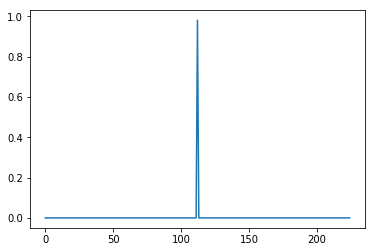

In [34]:
print("P under log10(abs())")
plt.plot(P_Matrix[round(0.5*inputsize)][:])

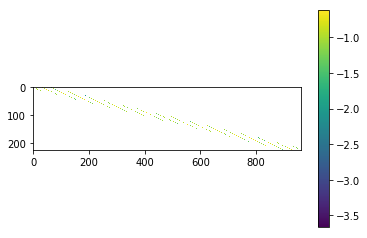

In [35]:
R = opt_par[1][0]
R_Matrix = np.zeros([k**2,n**2])
for i in range(k):
    for j in range(k):
        C = R[i][j]
        for l in range(3):
            for m in range(3):
                R_Matrix[k*i+j][n*(2*i+l)+(2*j+m)] = C[l][m]
plt.imshow(np.log10(np.abs(R_Matrix)))
plt.colorbar()

R under log10(abs())


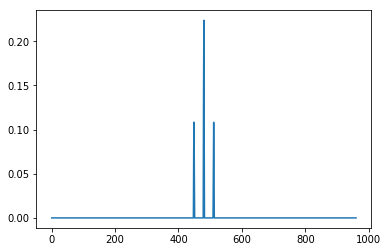

In [36]:
print("R under log10(abs())")
plt.plot(R_Matrix[:][round(0.5*outputsize)])

## Compare

Text(0, 0.5, 'Residual')

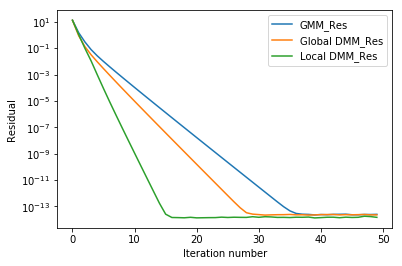

In [37]:
plt.semilogy(GMM_Res, label = 'GMM_Res')
plt.semilogy(DMM_Res, label = 'Global DMM_Res')
plt.semilogy(gmm.get_gmg_convergence(), label = 'Local DMM_Res')
plt.legend(loc='upper right')
plt.xlabel('Iteration number')
plt.ylabel('Residual')